# Week 22: Trading Strategy System Design

## 🎯 Learning Objectives

By the end of this notebook, you will be able to:
- **Design** a complete trading strategy system from data to execution
- **Implement** production-ready strategy patterns
- **Build** modular, testable trading components
- **Integrate** risk management into the strategy pipeline
- **Deploy** strategies with proper monitoring and controls

---

## System Overview

```
┌─────────────────────────────────────────────────────────────────────────┐
│                    TRADING STRATEGY SYSTEM                               │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  ┌──────────────┐    ┌──────────────┐    ┌──────────────┐               │
│  │   Alpha      │───▶│   Signal     │───▶│    Risk      │               │
│  │  Generation  │    │  Processing  │    │   Filter     │               │
│  └──────────────┘    └──────────────┘    └──────────────┘               │
│         │                   │                   │                        │
│         ▼                   ▼                   ▼                        │
│  ┌──────────────┐    ┌──────────────┐    ┌──────────────┐               │
│  │   Position   │◀───│   Order      │◀───│  Execution   │               │
│  │   Manager    │    │   Manager    │    │   Engine     │               │
│  └──────────────┘    └──────────────┘    └──────────────┘               │
│                                                                          │
└─────────────────────────────────────────────────────────────────────────┘
```

In [1]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Any, Callable, Tuple
from enum import Enum, auto
from abc import ABC, abstractmethod
from collections import deque, defaultdict
import time
import uuid
import logging
import warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('TradingStrategy')

np.random.seed(42)
print("✅ Libraries loaded!")
print("📈 Trading Strategy System Design")

✅ Libraries loaded!
📈 Trading Strategy System Design


---

## Part 1: Core Data Structures

### 1.1 Market Data Types

In [2]:
# ============================================================================
# ENUMERATIONS
# ============================================================================

class Side(Enum):
    BUY = "BUY"
    SELL = "SELL"

class OrderType(Enum):
    MARKET = "MARKET"
    LIMIT = "LIMIT"
    STOP = "STOP"
    STOP_LIMIT = "STOP_LIMIT"

class OrderStatus(Enum):
    PENDING = "PENDING"
    SUBMITTED = "SUBMITTED"
    FILLED = "FILLED"
    PARTIALLY_FILLED = "PARTIALLY_FILLED"
    CANCELLED = "CANCELLED"
    REJECTED = "REJECTED"

class SignalStrength(Enum):
    STRONG_SELL = -2
    SELL = -1
    NEUTRAL = 0
    BUY = 1
    STRONG_BUY = 2


# ============================================================================
# DATA CLASSES
# ============================================================================

@dataclass
class Bar:
    """OHLCV bar data"""
    symbol: str
    timestamp: int  # Unix timestamp in nanoseconds
    open: float
    high: float
    low: float
    close: float
    volume: int
    vwap: float = 0.0

@dataclass
class Quote:
    """Level 1 quote data"""
    symbol: str
    timestamp: int
    bid_price: float
    bid_size: int
    ask_price: float
    ask_size: int
    
    @property
    def mid_price(self) -> float:
        return (self.bid_price + self.ask_price) / 2
    
    @property
    def spread(self) -> float:
        return self.ask_price - self.bid_price

@dataclass
class Trade:
    """Trade execution data"""
    symbol: str
    timestamp: int
    price: float
    size: int
    side: Side

@dataclass
class Signal:
    """Trading signal from strategy"""
    symbol: str
    timestamp: int
    strength: SignalStrength
    confidence: float  # 0.0 to 1.0
    target_position: float  # Target position size
    metadata: Dict[str, Any] = field(default_factory=dict)

@dataclass
class Order:
    """Order representation"""
    order_id: str
    symbol: str
    side: Side
    order_type: OrderType
    quantity: int
    price: Optional[float] = None  # For limit orders
    stop_price: Optional[float] = None  # For stop orders
    status: OrderStatus = OrderStatus.PENDING
    filled_quantity: int = 0
    avg_fill_price: float = 0.0
    created_at: int = 0
    updated_at: int = 0

@dataclass
class Position:
    """Position tracking"""
    symbol: str
    quantity: int = 0
    avg_price: float = 0.0
    market_price: float = 0.0
    realized_pnl: float = 0.0
    
    @property
    def unrealized_pnl(self) -> float:
        return self.quantity * (self.market_price - self.avg_price)
    
    @property
    def market_value(self) -> float:
        return self.quantity * self.market_price

print("✅ Data structures defined")

✅ Data structures defined


---

## Part 2: Alpha Generation Layer

### 2.1 Strategy Base Class

In [3]:
class Strategy(ABC):
    """
    Abstract base class for all trading strategies.
    Defines the interface that all strategies must implement.
    """
    
    def __init__(self, name: str, symbols: List[str]):
        self.name = name
        self.symbols = symbols
        self.positions: Dict[str, Position] = {s: Position(s) for s in symbols}
        self.is_active = True
        self.logger = logging.getLogger(f"Strategy.{name}")
    
    @abstractmethod
    def on_bar(self, bar: Bar) -> Optional[Signal]:
        """Process a new bar and optionally generate a signal"""
        pass
    
    @abstractmethod
    def on_quote(self, quote: Quote) -> Optional[Signal]:
        """Process a new quote and optionally generate a signal"""
        pass
    
    def on_fill(self, order: Order):
        """Handle order fill updates"""
        position = self.positions[order.symbol]
        if order.side == Side.BUY:
            new_quantity = position.quantity + order.filled_quantity
            if new_quantity != 0:
                position.avg_price = (
                    (position.quantity * position.avg_price + 
                     order.filled_quantity * order.avg_fill_price) / new_quantity
                )
            position.quantity = new_quantity
        else:  # SELL
            pnl = order.filled_quantity * (order.avg_fill_price - position.avg_price)
            position.realized_pnl += pnl
            position.quantity -= order.filled_quantity
    
    def get_position(self, symbol: str) -> Position:
        return self.positions.get(symbol, Position(symbol))

print("✅ Strategy base class defined")

✅ Strategy base class defined


### 2.2 Momentum Strategy Implementation

In [4]:
class MomentumStrategy(Strategy):
    """
    Dual moving average momentum strategy.
    Generates signals based on fast/slow MA crossover.
    """
    
    def __init__(self, symbols: List[str], 
                 fast_period: int = 10, 
                 slow_period: int = 30,
                 position_size: int = 100):
        super().__init__("MomentumStrategy", symbols)
        self.fast_period = fast_period
        self.slow_period = slow_period
        self.position_size = position_size
        
        # Price history per symbol
        self.price_history: Dict[str, deque] = {
            s: deque(maxlen=slow_period + 1) for s in symbols
        }
        
        # Previous signal state
        self.last_signal: Dict[str, SignalStrength] = {
            s: SignalStrength.NEUTRAL for s in symbols
        }
    
    def _calculate_ma(self, prices: List[float], period: int) -> float:
        if len(prices) < period:
            return 0.0
        return sum(prices[-period:]) / period
    
    def on_bar(self, bar: Bar) -> Optional[Signal]:
        if bar.symbol not in self.symbols:
            return None
        
        # Update price history
        self.price_history[bar.symbol].append(bar.close)
        prices = list(self.price_history[bar.symbol])
        
        if len(prices) < self.slow_period:
            return None
        
        # Calculate moving averages
        fast_ma = self._calculate_ma(prices, self.fast_period)
        slow_ma = self._calculate_ma(prices, self.slow_period)
        
        # Generate signal
        if fast_ma > slow_ma * 1.01:  # 1% threshold
            strength = SignalStrength.BUY
            target = self.position_size
        elif fast_ma < slow_ma * 0.99:
            strength = SignalStrength.SELL
            target = -self.position_size
        else:
            strength = SignalStrength.NEUTRAL
            target = 0
        
        # Only generate signal on change
        if strength != self.last_signal[bar.symbol]:
            self.last_signal[bar.symbol] = strength
            return Signal(
                symbol=bar.symbol,
                timestamp=bar.timestamp,
                strength=strength,
                confidence=min(abs(fast_ma - slow_ma) / slow_ma * 10, 1.0),
                target_position=target,
                metadata={'fast_ma': fast_ma, 'slow_ma': slow_ma}
            )
        return None
    
    def on_quote(self, quote: Quote) -> Optional[Signal]:
        # This strategy only uses bar data
        return None

# Demo
strategy = MomentumStrategy(['AAPL', 'GOOGL'], fast_period=5, slow_period=20)

# Simulate bars
prices = 100 + np.cumsum(np.random.randn(50) * 0.5)
signals = []

for i, price in enumerate(prices):
    bar = Bar(
        symbol='AAPL',
        timestamp=int(time.time_ns()) + i * 1_000_000_000,
        open=price,
        high=price * 1.01,
        low=price * 0.99,
        close=price,
        volume=10000
    )
    signal = strategy.on_bar(bar)
    if signal:
        signals.append(signal)
        print(f"Signal: {signal.strength.name}, Confidence: {signal.confidence:.2f}")

print(f"\n✅ Generated {len(signals)} signals")

Signal: SELL, Confidence: 0.16
Signal: NEUTRAL, Confidence: 0.09
Signal: SELL, Confidence: 0.12
Signal: NEUTRAL, Confidence: 0.10
Signal: SELL, Confidence: 0.11

✅ Generated 5 signals


### 2.3 Mean Reversion Strategy

In [5]:
class MeanReversionStrategy(Strategy):
    """
    Statistical arbitrage mean reversion strategy.
    Uses z-score of price relative to moving average.
    """
    
    def __init__(self, symbols: List[str],
                 lookback: int = 20,
                 entry_z: float = 2.0,
                 exit_z: float = 0.5,
                 position_size: int = 100):
        super().__init__("MeanReversionStrategy", symbols)
        self.lookback = lookback
        self.entry_z = entry_z
        self.exit_z = exit_z
        self.position_size = position_size
        
        self.price_history: Dict[str, deque] = {
            s: deque(maxlen=lookback) for s in symbols
        }
        self.in_position: Dict[str, int] = {s: 0 for s in symbols}  # -1, 0, 1
    
    def _calculate_zscore(self, prices: List[float], current: float) -> float:
        if len(prices) < self.lookback:
            return 0.0
        mean = np.mean(prices)
        std = np.std(prices)
        if std == 0:
            return 0.0
        return (current - mean) / std
    
    def on_bar(self, bar: Bar) -> Optional[Signal]:
        if bar.symbol not in self.symbols:
            return None
        
        prices = list(self.price_history[bar.symbol])
        self.price_history[bar.symbol].append(bar.close)
        
        if len(prices) < self.lookback:
            return None
        
        z_score = self._calculate_zscore(prices, bar.close)
        current_pos = self.in_position[bar.symbol]
        
        signal = None
        
        # Entry logic
        if current_pos == 0:
            if z_score < -self.entry_z:
                # Price too low, expect reversion up
                signal = Signal(
                    symbol=bar.symbol,
                    timestamp=bar.timestamp,
                    strength=SignalStrength.BUY,
                    confidence=min(abs(z_score) / 3, 1.0),
                    target_position=self.position_size,
                    metadata={'z_score': z_score, 'action': 'entry_long'}
                )
                self.in_position[bar.symbol] = 1
            elif z_score > self.entry_z:
                # Price too high, expect reversion down
                signal = Signal(
                    symbol=bar.symbol,
                    timestamp=bar.timestamp,
                    strength=SignalStrength.SELL,
                    confidence=min(abs(z_score) / 3, 1.0),
                    target_position=-self.position_size,
                    metadata={'z_score': z_score, 'action': 'entry_short'}
                )
                self.in_position[bar.symbol] = -1
        
        # Exit logic
        elif current_pos == 1 and z_score > -self.exit_z:
            signal = Signal(
                symbol=bar.symbol,
                timestamp=bar.timestamp,
                strength=SignalStrength.NEUTRAL,
                confidence=1.0,
                target_position=0,
                metadata={'z_score': z_score, 'action': 'exit_long'}
            )
            self.in_position[bar.symbol] = 0
        
        elif current_pos == -1 and z_score < self.exit_z:
            signal = Signal(
                symbol=bar.symbol,
                timestamp=bar.timestamp,
                strength=SignalStrength.NEUTRAL,
                confidence=1.0,
                target_position=0,
                metadata={'z_score': z_score, 'action': 'exit_short'}
            )
            self.in_position[bar.symbol] = 0
        
        return signal
    
    def on_quote(self, quote: Quote) -> Optional[Signal]:
        return None

# Demo
mr_strategy = MeanReversionStrategy(['SPY'], lookback=20, entry_z=1.5)

# Generate mean-reverting prices
prices = 100 + 5 * np.sin(np.linspace(0, 4*np.pi, 100)) + np.random.randn(100) * 0.5
mr_signals = []

for i, price in enumerate(prices):
    bar = Bar('SPY', i, price, price*1.01, price*0.99, price, 10000)
    signal = mr_strategy.on_bar(bar)
    if signal:
        mr_signals.append((i, signal))

print(f"Mean Reversion Strategy Signals:")
for idx, sig in mr_signals[:5]:
    print(f"  Bar {idx}: {sig.metadata['action']}, z={sig.metadata['z_score']:.2f}")

Mean Reversion Strategy Signals:
  Bar 22: entry_long, z=-1.94
  Bar 43: exit_long, z=-0.35
  Bar 47: entry_short, z=2.29
  Bar 67: exit_short, z=0.21
  Bar 71: entry_long, z=-1.70


---

## Part 3: Risk Management Layer

### 3.1 Risk Manager

In [6]:
@dataclass
class RiskLimits:
    """Risk limit configuration"""
    max_position_size: int = 1000  # Max shares per symbol
    max_position_value: float = 100000  # Max $ value per position
    max_portfolio_value: float = 1000000  # Max total portfolio value
    max_daily_loss: float = 10000  # Max daily loss
    max_order_size: int = 500  # Max single order size
    max_concentration: float = 0.25  # Max % in single position

class RiskManager:
    """
    Pre-trade and post-trade risk management.
    Validates signals and monitors portfolio risk.
    """
    
    def __init__(self, limits: RiskLimits):
        self.limits = limits
        self.daily_pnl = 0.0
        self.positions: Dict[str, Position] = {}
        self.blocked_symbols: set = set()
        self.logger = logging.getLogger("RiskManager")
    
    def validate_signal(self, signal: Signal, 
                       current_position: Position,
                       current_price: float) -> Tuple[bool, str]:
        """Validate if a signal passes risk checks"""
        
        # Check if symbol is blocked
        if signal.symbol in self.blocked_symbols:
            return False, f"Symbol {signal.symbol} is blocked"
        
        # Check daily loss limit
        if self.daily_pnl <= -self.limits.max_daily_loss:
            return False, "Daily loss limit reached"
        
        # Calculate proposed position
        proposed_quantity = signal.target_position
        
        # Check position size limit
        if abs(proposed_quantity) > self.limits.max_position_size:
            return False, f"Position size {proposed_quantity} exceeds limit {self.limits.max_position_size}"
        
        # Check position value limit
        proposed_value = abs(proposed_quantity) * current_price
        if proposed_value > self.limits.max_position_value:
            return False, f"Position value ${proposed_value:,.0f} exceeds limit"
        
        # Check order size
        order_size = abs(proposed_quantity - current_position.quantity)
        if order_size > self.limits.max_order_size:
            return False, f"Order size {order_size} exceeds limit {self.limits.max_order_size}"
        
        return True, "Approved"
    
    def calculate_position_size(self, signal: Signal,
                                current_price: float,
                                portfolio_value: float) -> int:
        """
        Calculate risk-adjusted position size.
        Uses volatility-based position sizing.
        """
        # Base position from signal
        base_size = abs(signal.target_position)
        
        # Adjust by confidence
        adjusted_size = int(base_size * signal.confidence)
        
        # Check concentration limit
        max_size_by_conc = int(
            (portfolio_value * self.limits.max_concentration) / current_price
        )
        adjusted_size = min(adjusted_size, max_size_by_conc)
        
        # Apply hard limits
        adjusted_size = min(adjusted_size, self.limits.max_position_size)
        adjusted_size = min(adjusted_size, self.limits.max_order_size)
        
        # Preserve direction
        if signal.target_position < 0:
            adjusted_size = -adjusted_size
        
        return adjusted_size
    
    def update_daily_pnl(self, pnl_change: float):
        """Update daily P&L tracking"""
        self.daily_pnl += pnl_change
        
        if self.daily_pnl <= -self.limits.max_daily_loss * 0.8:
            self.logger.warning(f"Approaching daily loss limit: ${self.daily_pnl:,.2f}")
    
    def reset_daily(self):
        """Reset daily counters (call at market open)"""
        self.daily_pnl = 0.0
        self.blocked_symbols.clear()

# Demo
risk_mgr = RiskManager(RiskLimits(
    max_position_size=500,
    max_daily_loss=5000
))

test_signal = Signal(
    symbol='AAPL',
    timestamp=time.time_ns(),
    strength=SignalStrength.BUY,
    confidence=0.8,
    target_position=300
)

is_valid, reason = risk_mgr.validate_signal(
    test_signal, 
    Position('AAPL', 0), 
    current_price=150.0
)

print(f"Signal validation: {is_valid} - {reason}")

# Calculate position size
size = risk_mgr.calculate_position_size(test_signal, 150.0, 500000)
print(f"Recommended position size: {size} shares")

Signal validation: True - Approved
Recommended position size: 240 shares


---

## Part 4: Order Management System

### 4.1 Order Manager

In [7]:
class OrderManager:
    """
    Manages order lifecycle from creation to fill.
    Handles order state transitions and tracking.
    """
    
    def __init__(self):
        self.orders: Dict[str, Order] = {}
        self.pending_orders: Dict[str, List[str]] = defaultdict(list)  # symbol -> order_ids
        self.fill_callbacks: List[Callable] = []
        self.logger = logging.getLogger("OrderManager")
    
    def create_order(self, symbol: str, side: Side, 
                     order_type: OrderType, quantity: int,
                     price: Optional[float] = None) -> Order:
        """Create a new order"""
        order = Order(
            order_id=str(uuid.uuid4())[:8],
            symbol=symbol,
            side=side,
            order_type=order_type,
            quantity=quantity,
            price=price,
            status=OrderStatus.PENDING,
            created_at=time.time_ns()
        )
        self.orders[order.order_id] = order
        self.pending_orders[symbol].append(order.order_id)
        self.logger.info(f"Created order: {order.order_id} {side.value} {quantity} {symbol}")
        return order
    
    def submit_order(self, order_id: str) -> bool:
        """Submit order to exchange"""
        if order_id not in self.orders:
            return False
        
        order = self.orders[order_id]
        order.status = OrderStatus.SUBMITTED
        order.updated_at = time.time_ns()
        self.logger.info(f"Submitted order: {order_id}")
        return True
    
    def fill_order(self, order_id: str, fill_quantity: int, 
                   fill_price: float) -> bool:
        """Process order fill"""
        if order_id not in self.orders:
            return False
        
        order = self.orders[order_id]
        
        # Update fill info
        total_filled = order.filled_quantity + fill_quantity
        order.avg_fill_price = (
            (order.avg_fill_price * order.filled_quantity + 
             fill_price * fill_quantity) / total_filled
        )
        order.filled_quantity = total_filled
        order.updated_at = time.time_ns()
        
        # Update status
        if order.filled_quantity >= order.quantity:
            order.status = OrderStatus.FILLED
            self.pending_orders[order.symbol].remove(order_id)
        else:
            order.status = OrderStatus.PARTIALLY_FILLED
        
        # Notify callbacks
        for callback in self.fill_callbacks:
            callback(order)
        
        self.logger.info(
            f"Fill: {order_id} {fill_quantity}@{fill_price:.2f} "
            f"(Total: {order.filled_quantity}/{order.quantity})"
        )
        return True
    
    def cancel_order(self, order_id: str) -> bool:
        """Cancel an order"""
        if order_id not in self.orders:
            return False
        
        order = self.orders[order_id]
        if order.status in [OrderStatus.FILLED, OrderStatus.CANCELLED]:
            return False
        
        order.status = OrderStatus.CANCELLED
        order.updated_at = time.time_ns()
        if order_id in self.pending_orders[order.symbol]:
            self.pending_orders[order.symbol].remove(order_id)
        
        self.logger.info(f"Cancelled order: {order_id}")
        return True
    
    def get_open_orders(self, symbol: Optional[str] = None) -> List[Order]:
        """Get all open orders, optionally filtered by symbol"""
        open_statuses = [OrderStatus.PENDING, OrderStatus.SUBMITTED, OrderStatus.PARTIALLY_FILLED]
        orders = [
            o for o in self.orders.values() 
            if o.status in open_statuses
        ]
        if symbol:
            orders = [o for o in orders if o.symbol == symbol]
        return orders
    
    def register_fill_callback(self, callback: Callable):
        """Register callback for fill notifications"""
        self.fill_callbacks.append(callback)

# Demo
order_mgr = OrderManager()

# Create and submit order
order = order_mgr.create_order('AAPL', Side.BUY, OrderType.LIMIT, 100, price=150.0)
order_mgr.submit_order(order.order_id)

# Simulate partial fills
order_mgr.fill_order(order.order_id, 50, 149.95)
order_mgr.fill_order(order.order_id, 50, 150.00)

print(f"\nOrder status: {order.status.value}")
print(f"Avg fill price: ${order.avg_fill_price:.2f}")

2026-01-24 01:25:15,704 - OrderManager - INFO - Created order: df5ae685 BUY 100 AAPL
2026-01-24 01:25:15,705 - OrderManager - INFO - Submitted order: df5ae685
2026-01-24 01:25:15,705 - OrderManager - INFO - Fill: df5ae685 50@149.95 (Total: 50/100)
2026-01-24 01:25:15,705 - OrderManager - INFO - Fill: df5ae685 50@150.00 (Total: 100/100)



Order status: FILLED
Avg fill price: $149.97


---

## Part 5: Execution Engine

### 5.1 Smart Order Router

In [8]:
class ExecutionAlgo(Enum):
    """Execution algorithm types"""
    MARKET = "MARKET"  # Immediate execution
    TWAP = "TWAP"      # Time-weighted average price
    VWAP = "VWAP"      # Volume-weighted average price
    POV = "POV"        # Percentage of volume
    ICEBERG = "ICEBERG"  # Hidden quantity

@dataclass
class ExecutionSlice:
    """A slice of an order to execute"""
    quantity: int
    scheduled_time: int
    max_price: Optional[float] = None

class ExecutionEngine:
    """
    Smart order routing and execution algorithms.
    Breaks large orders into smaller slices.
    """
    
    def __init__(self, order_manager: OrderManager):
        self.order_manager = order_manager
        self.active_algos: Dict[str, List[ExecutionSlice]] = {}
        self.logger = logging.getLogger("ExecutionEngine")
    
    def execute_twap(self, symbol: str, side: Side, 
                     total_quantity: int, duration_minutes: int,
                     num_slices: int = 10) -> str:
        """
        Time-Weighted Average Price execution.
        Splits order evenly over time.
        """
        slice_quantity = total_quantity // num_slices
        interval_ns = (duration_minutes * 60 * 1_000_000_000) // num_slices
        
        slices = []
        current_time = time.time_ns()
        
        for i in range(num_slices):
            qty = slice_quantity
            if i == num_slices - 1:
                # Put remainder in last slice
                qty = total_quantity - (slice_quantity * (num_slices - 1))
            
            slices.append(ExecutionSlice(
                quantity=qty,
                scheduled_time=current_time + (i * interval_ns)
            ))
        
        algo_id = f"TWAP_{symbol}_{str(uuid.uuid4())[:8]}"
        self.active_algos[algo_id] = slices
        
        self.logger.info(
            f"Created TWAP algo {algo_id}: {total_quantity} {symbol} "
            f"over {duration_minutes}min in {num_slices} slices"
        )
        return algo_id
    
    def execute_vwap(self, symbol: str, side: Side,
                     total_quantity: int, 
                     volume_profile: List[float]) -> str:
        """
        Volume-Weighted Average Price execution.
        Distributes based on historical volume profile.
        """
        # Normalize volume profile
        total_vol = sum(volume_profile)
        weights = [v / total_vol for v in volume_profile]
        
        slices = []
        current_time = time.time_ns()
        interval_ns = 60 * 1_000_000_000  # 1 minute intervals
        
        for i, weight in enumerate(weights):
            qty = int(total_quantity * weight)
            if qty > 0:
                slices.append(ExecutionSlice(
                    quantity=qty,
                    scheduled_time=current_time + (i * interval_ns)
                ))
        
        algo_id = f"VWAP_{symbol}_{str(uuid.uuid4())[:8]}"
        self.active_algos[algo_id] = slices
        
        self.logger.info(f"Created VWAP algo {algo_id}: {total_quantity} {symbol}")
        return algo_id
    
    def execute_iceberg(self, symbol: str, side: Side,
                        total_quantity: int, 
                        display_quantity: int,
                        limit_price: float) -> str:
        """
        Iceberg order - shows only a portion of full size.
        Replenishes displayed quantity as it fills.
        """
        slices = []
        remaining = total_quantity
        current_time = time.time_ns()
        
        while remaining > 0:
            qty = min(display_quantity, remaining)
            slices.append(ExecutionSlice(
                quantity=qty,
                scheduled_time=current_time,
                max_price=limit_price if side == Side.BUY else None
            ))
            remaining -= qty
            current_time += 1_000_000  # Small delay between refreshes
        
        algo_id = f"ICE_{symbol}_{str(uuid.uuid4())[:8]}"
        self.active_algos[algo_id] = slices
        
        self.logger.info(
            f"Created Iceberg algo {algo_id}: {total_quantity} {symbol} "
            f"(display: {display_quantity})"
        )
        return algo_id
    
    def get_algo_progress(self, algo_id: str) -> Dict[str, Any]:
        """Get progress of an execution algo"""
        if algo_id not in self.active_algos:
            return {'error': 'Algo not found'}
        
        slices = self.active_algos[algo_id]
        total_qty = sum(s.quantity for s in slices)
        executed_qty = sum(
            s.quantity for s in slices 
            if s.scheduled_time < time.time_ns()
        )
        
        return {
            'algo_id': algo_id,
            'total_quantity': total_qty,
            'executed_quantity': executed_qty,
            'remaining_quantity': total_qty - executed_qty,
            'progress_pct': (executed_qty / total_qty) * 100 if total_qty > 0 else 0,
            'remaining_slices': len([s for s in slices if s.scheduled_time >= time.time_ns()])
        }

# Demo
exec_engine = ExecutionEngine(order_mgr)

# Create TWAP execution
twap_id = exec_engine.execute_twap('AAPL', Side.BUY, 10000, duration_minutes=30, num_slices=10)

# Create VWAP with typical U-shaped volume profile
volume_profile = [1.5, 1.0, 0.8, 0.7, 0.6, 0.6, 0.7, 0.8, 1.0, 1.5]  # U-shaped
vwap_id = exec_engine.execute_vwap('GOOGL', Side.SELL, 5000, volume_profile)

# Create iceberg
ice_id = exec_engine.execute_iceberg('MSFT', Side.BUY, 20000, display_quantity=500, limit_price=400.0)

print("\nExecution Algos Created:")
print(f"  TWAP: {twap_id}")
print(f"  VWAP: {vwap_id}")
print(f"  Iceberg: {ice_id}")

2026-01-24 01:25:15,886 - ExecutionEngine - INFO - Created TWAP algo TWAP_AAPL_bce18790: 10000 AAPL over 30min in 10 slices
2026-01-24 01:25:15,888 - ExecutionEngine - INFO - Created VWAP algo VWAP_GOOGL_4e3dbdda: 5000 GOOGL
2026-01-24 01:25:15,888 - ExecutionEngine - INFO - Created Iceberg algo ICE_MSFT_ebdc0e95: 20000 MSFT (display: 500)



Execution Algos Created:
  TWAP: TWAP_AAPL_bce18790
  VWAP: VWAP_GOOGL_4e3dbdda
  Iceberg: ICE_MSFT_ebdc0e95


---

## Part 6: Portfolio Manager

### 6.1 Portfolio Tracking

In [9]:
class PortfolioManager:
    """
    Portfolio-level tracking and analytics.
    Manages positions, P&L, and exposure.
    """
    
    def __init__(self, initial_cash: float = 1_000_000):
        self.cash = initial_cash
        self.initial_cash = initial_cash
        self.positions: Dict[str, Position] = {}
        self.trade_history: List[Dict] = []
        self.logger = logging.getLogger("PortfolioManager")
    
    def update_position(self, symbol: str, quantity_change: int, 
                        price: float) -> Position:
        """Update position after a fill"""
        if symbol not in self.positions:
            self.positions[symbol] = Position(symbol)
        
        pos = self.positions[symbol]
        
        # Calculate cash impact
        cash_impact = -quantity_change * price
        self.cash += cash_impact
        
        # Update position
        if quantity_change > 0:  # Buy
            if pos.quantity + quantity_change != 0:
                pos.avg_price = (
                    (pos.quantity * pos.avg_price + quantity_change * price) /
                    (pos.quantity + quantity_change)
                )
            pos.quantity += quantity_change
        else:  # Sell
            sell_quantity = abs(quantity_change)
            if pos.quantity > 0:  # Closing long
                realized = sell_quantity * (price - pos.avg_price)
                pos.realized_pnl += realized
            pos.quantity += quantity_change
        
        pos.market_price = price
        
        # Record trade
        self.trade_history.append({
            'timestamp': time.time_ns(),
            'symbol': symbol,
            'quantity': quantity_change,
            'price': price,
            'cash_impact': cash_impact
        })
        
        return pos
    
    def update_market_prices(self, prices: Dict[str, float]):
        """Update market prices for P&L calculation"""
        for symbol, price in prices.items():
            if symbol in self.positions:
                self.positions[symbol].market_price = price
    
    @property
    def total_value(self) -> float:
        """Total portfolio value (cash + positions)"""
        position_value = sum(p.market_value for p in self.positions.values())
        return self.cash + position_value
    
    @property
    def total_pnl(self) -> float:
        """Total P&L (realized + unrealized)"""
        return self.total_value - self.initial_cash
    
    @property
    def realized_pnl(self) -> float:
        """Total realized P&L"""
        return sum(p.realized_pnl for p in self.positions.values())
    
    @property
    def unrealized_pnl(self) -> float:
        """Total unrealized P&L"""
        return sum(p.unrealized_pnl for p in self.positions.values())
    
    def get_exposure(self) -> Dict[str, float]:
        """Get exposure breakdown"""
        total = self.total_value
        exposure = {}
        
        for symbol, pos in self.positions.items():
            if pos.quantity != 0:
                exposure[symbol] = pos.market_value / total
        
        exposure['cash'] = self.cash / total
        return exposure
    
    def summary(self) -> str:
        """Generate portfolio summary"""
        lines = [
            "\n" + "="*60,
            "PORTFOLIO SUMMARY",
            "="*60,
            f"Total Value:     ${self.total_value:>15,.2f}",
            f"Cash:            ${self.cash:>15,.2f}",
            f"Positions Value: ${(self.total_value - self.cash):>15,.2f}",
            "-"*60,
            f"Total P&L:       ${self.total_pnl:>15,.2f}",
            f"  Realized:      ${self.realized_pnl:>15,.2f}",
            f"  Unrealized:    ${self.unrealized_pnl:>15,.2f}",
            "-"*60,
            "Positions:"
        ]
        
        for symbol, pos in self.positions.items():
            if pos.quantity != 0:
                lines.append(
                    f"  {symbol:8} {pos.quantity:>8} @ ${pos.avg_price:.2f} "
                    f"(P&L: ${pos.unrealized_pnl:>10,.2f})"
                )
        
        lines.append("="*60)
        return "\n".join(lines)

# Demo
portfolio = PortfolioManager(initial_cash=1_000_000)

# Simulate some trades
portfolio.update_position('AAPL', 100, 150.0)   # Buy 100 AAPL @ $150
portfolio.update_position('GOOGL', 50, 140.0)   # Buy 50 GOOGL @ $140
portfolio.update_position('AAPL', -50, 155.0)   # Sell 50 AAPL @ $155 (profit)

# Update market prices
portfolio.update_market_prices({'AAPL': 157.0, 'GOOGL': 138.0})

print(portfolio.summary())


PORTFOLIO SUMMARY
Total Value:     $   1,000,500.00
Cash:            $     985,750.00
Positions Value: $      14,750.00
------------------------------------------------------------
Total P&L:       $         500.00
  Realized:      $         250.00
  Unrealized:    $         250.00
------------------------------------------------------------
Positions:
  AAPL           50 @ $150.00 (P&L: $    350.00)
  GOOGL          50 @ $140.00 (P&L: $   -100.00)


---

## Part 7: Complete Trading System Integration

### 7.1 Putting It All Together

In [10]:
class TradingSystem:
    """
    Complete trading system integrating all components.
    Event-driven architecture for signal to execution.
    """
    
    def __init__(self, initial_capital: float = 1_000_000):
        # Initialize components
        self.portfolio = PortfolioManager(initial_capital)
        self.risk_manager = RiskManager(RiskLimits())
        self.order_manager = OrderManager()
        self.execution_engine = ExecutionEngine(self.order_manager)
        
        self.strategies: List[Strategy] = []
        self.is_running = False
        self.logger = logging.getLogger("TradingSystem")
        
        # Wire up callbacks
        self.order_manager.register_fill_callback(self._on_fill)
    
    def add_strategy(self, strategy: Strategy):
        """Add a strategy to the system"""
        self.strategies.append(strategy)
        self.logger.info(f"Added strategy: {strategy.name}")
    
    def on_bar(self, bar: Bar):
        """Process incoming bar data"""
        if not self.is_running:
            return
        
        # Update market prices
        self.portfolio.update_market_prices({bar.symbol: bar.close})
        
        # Generate signals from all strategies
        for strategy in self.strategies:
            signal = strategy.on_bar(bar)
            if signal:
                self._process_signal(signal, bar.close)
    
    def _process_signal(self, signal: Signal, current_price: float):
        """Process a trading signal through risk and execution"""
        
        # Get current position
        current_pos = self.portfolio.positions.get(
            signal.symbol, Position(signal.symbol)
        )
        
        # Validate through risk manager
        is_valid, reason = self.risk_manager.validate_signal(
            signal, current_pos, current_price
        )
        
        if not is_valid:
            self.logger.warning(f"Signal rejected: {reason}")
            return
        
        # Calculate position size
        target_size = self.risk_manager.calculate_position_size(
            signal, current_price, self.portfolio.total_value
        )
        
        # Calculate order quantity
        order_quantity = target_size - current_pos.quantity
        
        if order_quantity == 0:
            return
        
        # Create and submit order
        side = Side.BUY if order_quantity > 0 else Side.SELL
        order = self.order_manager.create_order(
            signal.symbol,
            side,
            OrderType.MARKET,
            abs(order_quantity)
        )
        self.order_manager.submit_order(order.order_id)
        
        # Simulate immediate fill for market orders
        slippage = 0.0001 * (1 if side == Side.BUY else -1)
        fill_price = current_price * (1 + slippage)
        self.order_manager.fill_order(
            order.order_id, 
            abs(order_quantity), 
            fill_price
        )
    
    def _on_fill(self, order: Order):
        """Handle order fills"""
        quantity = order.filled_quantity if order.side == Side.BUY else -order.filled_quantity
        self.portfolio.update_position(
            order.symbol,
            quantity,
            order.avg_fill_price
        )
    
    def start(self):
        """Start the trading system"""
        self.is_running = True
        self.risk_manager.reset_daily()
        self.logger.info("Trading system started")
    
    def stop(self):
        """Stop the trading system"""
        self.is_running = False
        self.logger.info("Trading system stopped")

print("✅ TradingSystem class defined")

✅ TradingSystem class defined


In [11]:
# Full System Demo

# Create trading system
trading_system = TradingSystem(initial_capital=1_000_000)

# Add strategies
momentum = MomentumStrategy(['AAPL', 'GOOGL'], fast_period=5, slow_period=20, position_size=100)
mean_rev = MeanReversionStrategy(['SPY'], lookback=15, entry_z=1.5, position_size=200)

trading_system.add_strategy(momentum)
trading_system.add_strategy(mean_rev)

# Start system
trading_system.start()

# Simulate market data
np.random.seed(42)
n_bars = 100

# Generate price paths
aapl_prices = 150 + np.cumsum(np.random.randn(n_bars) * 0.5)
googl_prices = 140 + np.cumsum(np.random.randn(n_bars) * 0.5)
spy_prices = 450 + 10 * np.sin(np.linspace(0, 4*np.pi, n_bars)) + np.random.randn(n_bars) * 0.5

# Run simulation
for i in range(n_bars):
    timestamp = int(time.time_ns()) + i * 1_000_000_000
    
    # Process each symbol
    for symbol, prices in [('AAPL', aapl_prices), ('GOOGL', googl_prices), ('SPY', spy_prices)]:
        bar = Bar(
            symbol=symbol,
            timestamp=timestamp,
            open=prices[i],
            high=prices[i] * 1.01,
            low=prices[i] * 0.99,
            close=prices[i],
            volume=100000
        )
        trading_system.on_bar(bar)

# Stop system
trading_system.stop()

# Print results
print(trading_system.portfolio.summary())

2026-01-24 01:25:16,228 - TradingSystem - INFO - Added strategy: MomentumStrategy
2026-01-24 01:25:16,230 - TradingSystem - INFO - Added strategy: MeanReversionStrategy
2026-01-24 01:25:16,231 - TradingSystem - INFO - Trading system started
2026-01-24 01:25:16,232 - OrderManager - INFO - Created order: 74adc821 SELL 10 AAPL
2026-01-24 01:25:16,233 - OrderManager - INFO - Submitted order: 74adc821
2026-01-24 01:25:16,233 - OrderManager - INFO - Fill: 74adc821 10@148.27 (Total: 10/10)
2026-01-24 01:25:16,233 - OrderManager - INFO - Created order: 8385d846 BUY 200 SPY
2026-01-24 01:25:16,233 - OrderManager - INFO - Submitted order: 8385d846
2026-01-24 01:25:16,233 - OrderManager - INFO - Fill: 8385d846 200@453.69 (Total: 200/200)
2026-01-24 01:25:16,234 - OrderManager - INFO - Created order: 830f2f03 BUY 10 AAPL
2026-01-24 01:25:16,235 - OrderManager - INFO - Submitted order: 830f2f03
2026-01-24 01:25:16,235 - OrderManager - INFO - Fill: 830f2f03 10@147.82 (Total: 10/10)
2026-01-24 01:25:


PORTFOLIO SUMMARY
Total Value:     $     992,913.57
Cash:            $   1,050,103.56
Positions Value: $     -57,189.98
------------------------------------------------------------
Total P&L:       $      -7,086.43
  Realized:      $      -4,340.35
  Unrealized:    $         709.70
------------------------------------------------------------
Positions:
  SPY          -127 @ $455.90 (P&L: $    709.70)


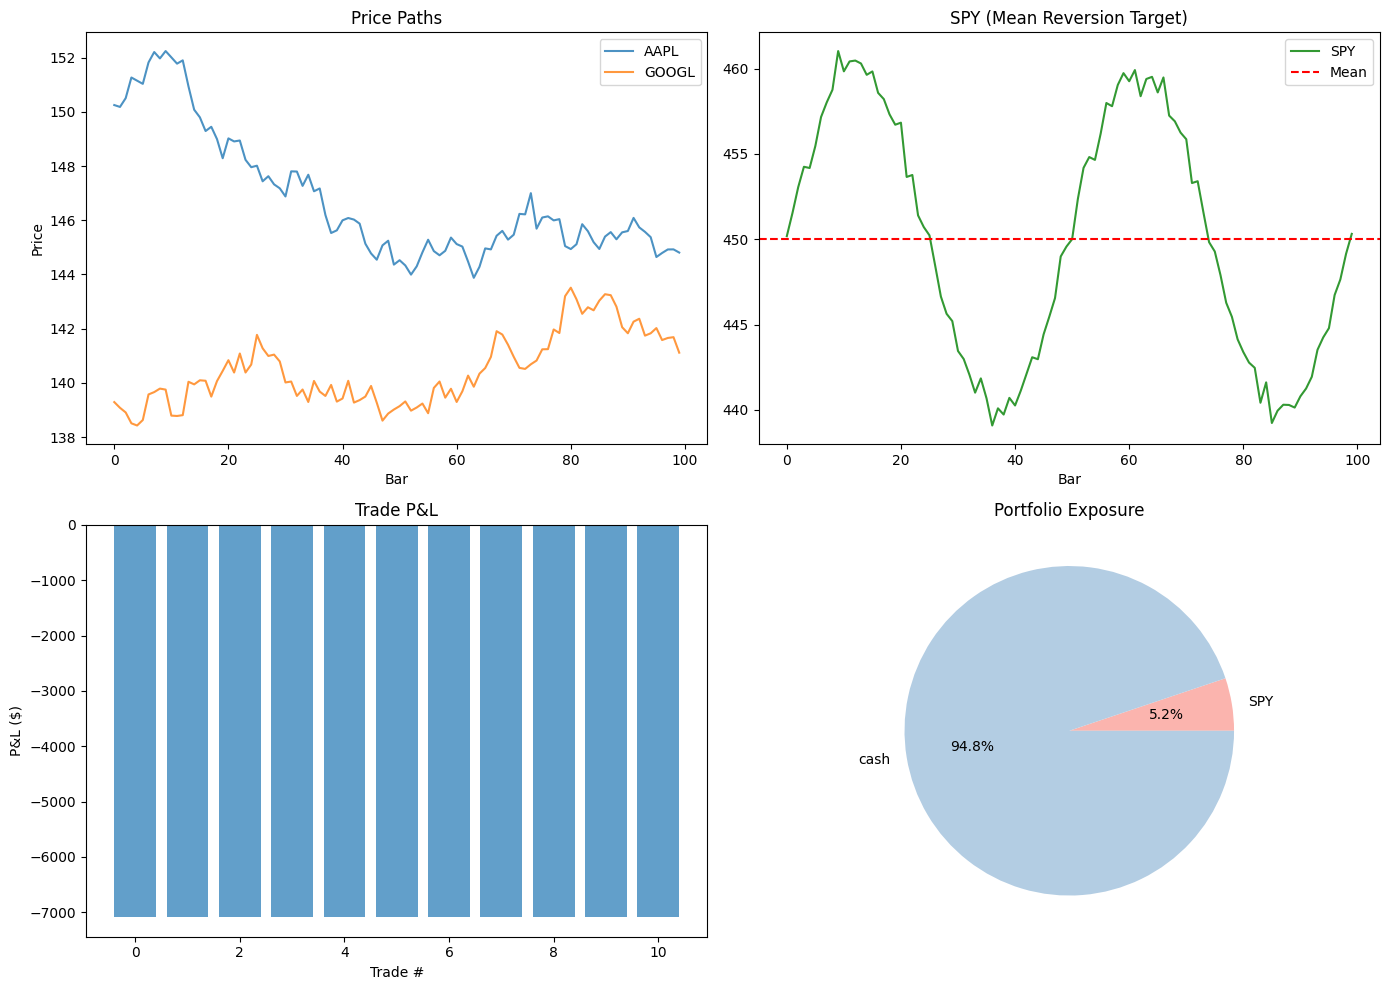


📊 Total trades executed: 11
📈 Final P&L: $-7,086.43


In [12]:
# Visualize Results

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Price paths
ax1 = axes[0, 0]
ax1.plot(aapl_prices, label='AAPL', alpha=0.8)
ax1.plot(googl_prices, label='GOOGL', alpha=0.8)
ax1.set_title('Price Paths')
ax1.legend()
ax1.set_xlabel('Bar')
ax1.set_ylabel('Price')

# SPY with mean reversion
ax2 = axes[0, 1]
ax2.plot(spy_prices, label='SPY', alpha=0.8, color='green')
ax2.axhline(np.mean(spy_prices), color='red', linestyle='--', label='Mean')
ax2.set_title('SPY (Mean Reversion Target)')
ax2.legend()
ax2.set_xlabel('Bar')

# P&L over time
ax3 = axes[1, 0]
trade_pnls = []
cumulative_pnl = 0
for trade in trading_system.portfolio.trade_history:
    # Simple approximation of running P&L
    trade_pnls.append(trading_system.portfolio.total_pnl)
ax3.bar(range(len(trade_pnls)), trade_pnls, alpha=0.7)
ax3.set_title('Trade P&L')
ax3.set_xlabel('Trade #')
ax3.set_ylabel('P&L ($)')

# Position exposure
ax4 = axes[1, 1]
exposure = trading_system.portfolio.get_exposure()
labels = list(exposure.keys())
sizes = [abs(v) for v in exposure.values()]
colors = ['green' if v > 0 else 'gray' for v in exposure.values()]
ax4.pie(sizes, labels=labels, autopct='%1.1f%%', colors=plt.cm.Pastel1.colors)
ax4.set_title('Portfolio Exposure')

plt.tight_layout()
plt.show()

print(f"\n📊 Total trades executed: {len(trading_system.portfolio.trade_history)}")
print(f"📈 Final P&L: ${trading_system.portfolio.total_pnl:,.2f}")

---

## Interview Questions

### System Design
1. How would you handle strategy priority when multiple strategies signal on the same symbol?
2. Design a system for strategy hot-swapping without system restart.
3. How do you ensure order execution fairness across strategies?

### Implementation
1. Implement a position reconciliation system.
2. How would you handle partial fills in your order manager?
3. Design a replay system for strategy debugging.

### Risk Management
1. How do you implement real-time risk monitoring?
2. Design a kill switch for emergency position liquidation.
3. How do you handle fat-finger order protection?

---

## Key Takeaways

| Component | Key Design Points |
|-----------|-------------------|
| Strategy | Abstract base class, stateless signal generation |
| Risk | Pre-trade validation, position limits, kill switches |
| Orders | State machine, idempotent operations |
| Execution | TWAP/VWAP/Iceberg algos, smart routing |
| Portfolio | Real-time P&L, exposure tracking |

---

## References

- *Trading and Exchanges* - Larry Harris
- *Algorithmic Trading* - Ernest Chan
- *Building Winning Algorithmic Trading Systems* - Kevin Davey
- *Quantitative Trading* - Ernest Chan